## Quantum Pokemon Classifier

In [1]:
from IPython.display import Image

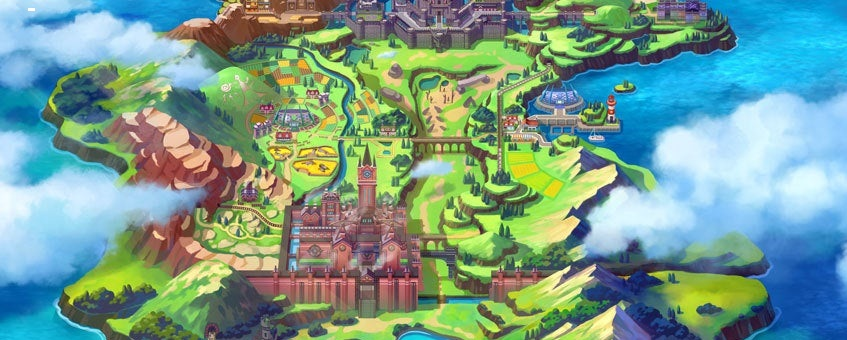

In [2]:
Image(filename="img/PokemonWorld.png")

O mundo pokemon é um local vasto, bonito e repleto de regiões, que possibilitam aventuras incriveis para os novos treinadores pokemon a cada geração. Mas além disso, é um mundo formidavel para os pesquisadores, que encaram um novo desafio: Uma região ainda não catalogada e repleta de mistérios e criaturas esperando para serem descobertas.

Nesse contexto, o Professor Carvalho, um pesquisador renomado cujo nome ecoa pelos corredores das mais prestigiadas instituições Pokémon, fica ansioso para começar a explorar e catalogar os Pokémon dessa nova região. No entanto, esse desafio é enorme e ele sabe que não poderia trabalhar nisso sozinho. Assim, ele toma uma decisão crucial: abrir vagas para novos pesquisadores em sua equipe, buscando mentes brilhantes e dispostas a enfrentar os desafios que essa jornada implica.

<!-- <p align="center">
  <img src="image/Professor_Oak_JN_anime.webp" alt="Mundo Pokemon">
</p> -->
![Professor Carvalho](img/Professor_Oak_JN_anime.webp)

A noticia que o professor Carvalho abriu vagas para pesquisadores correm por toda cidade e em questão de horas, centenas de curriculos inundam sua mesa. Assim, o professor começa avaliar um por um dos curriculos dos ansiosos treinadores e pesquisadores Pokémon. Entre eles, um em especial chama a atenção, o seu curriculo!

 Lá estava você, uma pessoa apaixonada pelo o que fazia, destemido e bla bla bla, igual a todas os outros candidatos, mas foi um detalhe em particular que despertou a curiosidade do Professor Carvalho: seu recente interesse e estudo em computação quântica.

No entanto, diante da perspetiva de explorar novas fronteiras e desvendar os mistérios do universo Pokémon de maneiras jamais imaginadas, ele decide abrir as portas para essa possibilidade intrigante e te informar para aparecer lá no outro dia de manhã.

No dia seguinte, logo pela manha, você está lá, parado diante da imponente porta do laboratório do Professor Carvalho, acompanhado de seu leal companheiro Pikachu. Em poucos minutos, a imagem do professor vai se construindo no fundo do escuro laboratorio dele e te recebe com um sorriso amigavel.


Ele se apresenta com pressa, mas não perde tempo, e logo te apresenta o seu desafio: ele deseja que você desenvolva um classificador para determinar se o primeiro tipo do Pokémon é normal ou aquático, e propõe a você utilizar computação quântica nessa tarefa. 

In [244]:
import pandas as pd
data = pd.read_csv('pokemon.csv')

### Data pre-processing

In [245]:
from sklearn.preprocessing import LabelEncoder
df = data.copy()
df.isnull().sum()
df.columns = df.columns.str.strip()
# filtering only items that type1 == "water" or type1 == "normal"
df = df[df['type1'].isin(['water', 'normal'])]
# apply label encoding to column 'type1', water == 1 and normal == 0
df['type1'] = LabelEncoder().fit_transform(df['type1'])
print(df[['name', 'type1','against_electric','against_rock']])

          name  type1  against_electric  against_rock
6     Squirtle      1               2.0           1.0
7    Wartortle      1               2.0           1.0
8    Blastoise      1               2.0           1.0
15      Pidgey      0               2.0           2.0
16   Pidgeotto      0               2.0           2.0
..         ...    ...               ...           ...
772   Silvally      0               1.0           1.0
774     Komala      0               1.0           1.0
778    Bruxish      1               2.0           1.0
779     Drampa      0               0.5           1.0
787  Tapu Fini      1               2.0           1.0

[219 rows x 4 columns]


### Separation of data for training, testing and normalization

In [246]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 42

X = df[['against_electric', 'against_rock']]
y = df['type1']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=algorithm_globals.random_seed)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### mapping classical data into a quantum circuit with ZZFeatureMap

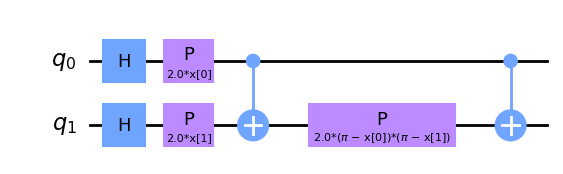

In [247]:
from qiskit.circuit.library import ZZFeatureMap
num_features = X_train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=-1)

### Ansatz

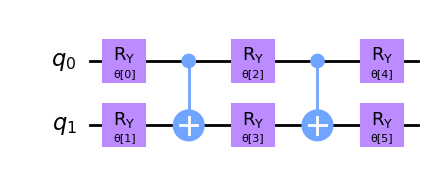

In [248]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=num_features, reps=4)
ansatz.decompose().draw(output="mpl", style="clifford", fold=-1)

In [249]:
from qiskit_algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=100)

### Sampler and Qiskit Runtime

In [250]:
from qiskit.primitives import Sampler
sampler = Sampler()

In [251]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.grid()
    plt.show()

### Classifier and Training

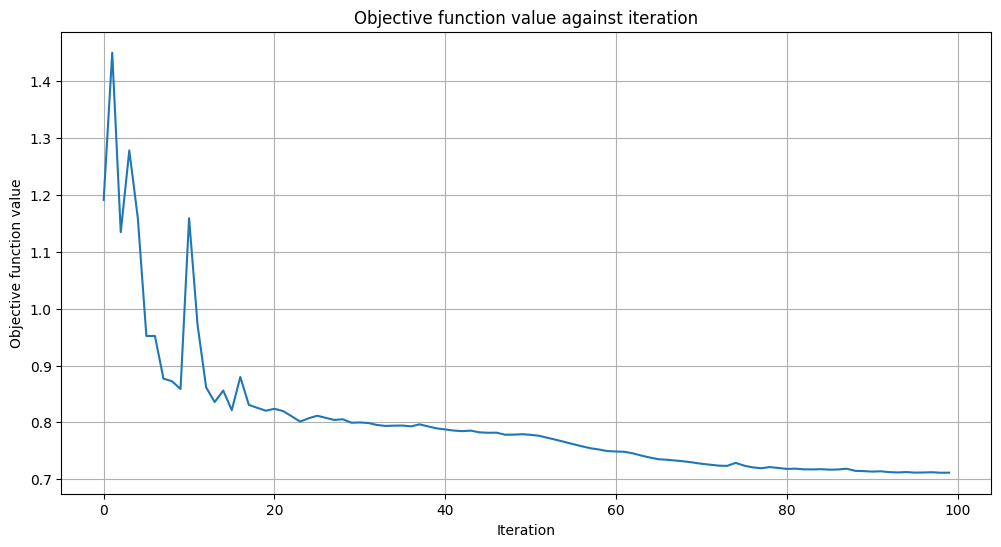

Training time: 58 seconds


In [252]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train.values)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [253]:
train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.81
Quantum VQC on the test dataset:     0.86


### referencias

- https://www.forbes.com/sites/olliebarder/2019/02/27/the-galar-region-in-pokemon-sword-and-shield-looks-a-lot-like-the-united-kingdom/
- https://pokemondb.net/move/rock-throw
- https://pokemon.fandom.com/pt-br/wiki/Professor_Carvalho_(anime)?file=Professor_Oak_JN_anime.png